<h4 align="center"> Tên đề tài :  Đánh giá khả năng trả nợ tín dụng của khách hàng trong 2 năm. </h4>

- Link Dataset : https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

### Import các thư viện cần thiết

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.utils import resample
from scipy import stats
import pydotplus
from collections import deque
import math
import numpy as np
import pandas as pd



Đọc dữ liệu từ file csv

In [2]:
train_df = pd.read_csv('./GiveMeSomeCredit/cs-training.csv').drop('Unnamed: 0', axis=1)
test_df = pd.read_csv('./GiveMeSomeCredit/cs-test.csv').drop('Unnamed: 0', axis=1)
entry_df = pd.read_csv('./GiveMeSomeCredit/sampleEntry.csv')

In [3]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
test_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [5]:
print(train_df.shape)
print(test_df.shape)
print(entry_df.shape)

(150000, 11)
(101503, 11)
(101503, 2)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

## Thông tin ý nghĩa của các cột dữ liệu trong bộ dữ liệu :
| Tên cột | Ý nghĩa | Kiểu dữ liệu |
| --- | --- | --- |
| SeriousDlqin2yrs | Người vay đã có lịch sử thanh toán chậm 90 ngày hoặc tệ hơn trong vòng 2 năm trước hay không | Y/N |
| RevolvingUtilizationOfUnsecuredLines | Tổng số dư trên thẻ tín dụng và các khoản vay cá nhân không được thế chấp, ngoại trừ bất kỳ khoản nợ trả góp nào như khoản vay ô tô, chia cho tổng hạn mức tín dụng | percentage |
| age | Tuổi của người vay theo năm | integer |
| NumberOfTime30-59DaysPastDueNotWorse | Số lần người vay đã bị trễ hạn 30-59 ngày nhưng không tệ hơn trong vòng 2 năm qua | integer |
| DebtRatio | Khoản thanh toán nợ hàng tháng, tiền cấp dưỡng, chi phí sinh hoạt chia cho thu nhập gộp hàng tháng |
| MonthlyIncome | Thu nhập hàng tháng của người vay | real |
| NumberOfOpenCreditLinesAndLoans | Số khoản vay mở (như khoản vay ô tô hoặc thế chấp) và các khoản vay tín dụng (ví dụ: thẻ tín dụng) | integer |
| NumberOfTimes90DaysLate | Số lần người vay bị trễ hạn 90 ngày hoặc hơn | integer |
| NumberRealEstateLoansOrLines | Số khoản vay bất động sản và các khoản vay thế chấp bao gồm cả các khoản vay thế chấp thế chấp | integer |
| NumberOfTime60-89DaysPastDueNotWorse | Số lần người vay bị trễ hạn 60-89 ngày nhưng không tệ hơn trong vòng 2 năm qua | integer |
| NumberOfDependents | Số người phụ thuộc trong gia đình không bao gồm bản thân họ (vợ / chồng, con cái, v.v.) | integer |


## 1. Khám phá dữ liệu (EDA)

In [7]:
train_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Kiểm tra dữ liệu có bị thiếu hay không

In [8]:
train_df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [9]:
# Điền giá trị thiếu
# Điền giá trị trung bình cho MonthlyIncome
train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].mean(), inplace=True)
# Điền giá trị trung vị cho NumberOfDependents
train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].mode()[0], inplace=True)

In [10]:
train_df.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Xử lý dữ liệu trùng lặp

In [11]:
# Đếm số hàng bị trùng
print(f'Duplicated rows : {train_df.duplicated().sum()}')

Duplicated rows : 767


In [12]:
# Xóa các hàng bị trùng
train_df.drop_duplicates(inplace=True)
# Kiểm tra lại
print(f'Check again Duplicated rows : {train_df.duplicated().sum()}')

Check again Duplicated rows : 0


In [13]:
train_df.shape

(149233, 11)

Vẽ biểu đồ 

In [14]:
def plot_scatter(df, col):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[col], df['SeriousDlqin2yrs'])
    plt.xlabel(col)
    plt.ylabel('SeriousDlqin2yrs')
    plt.show()


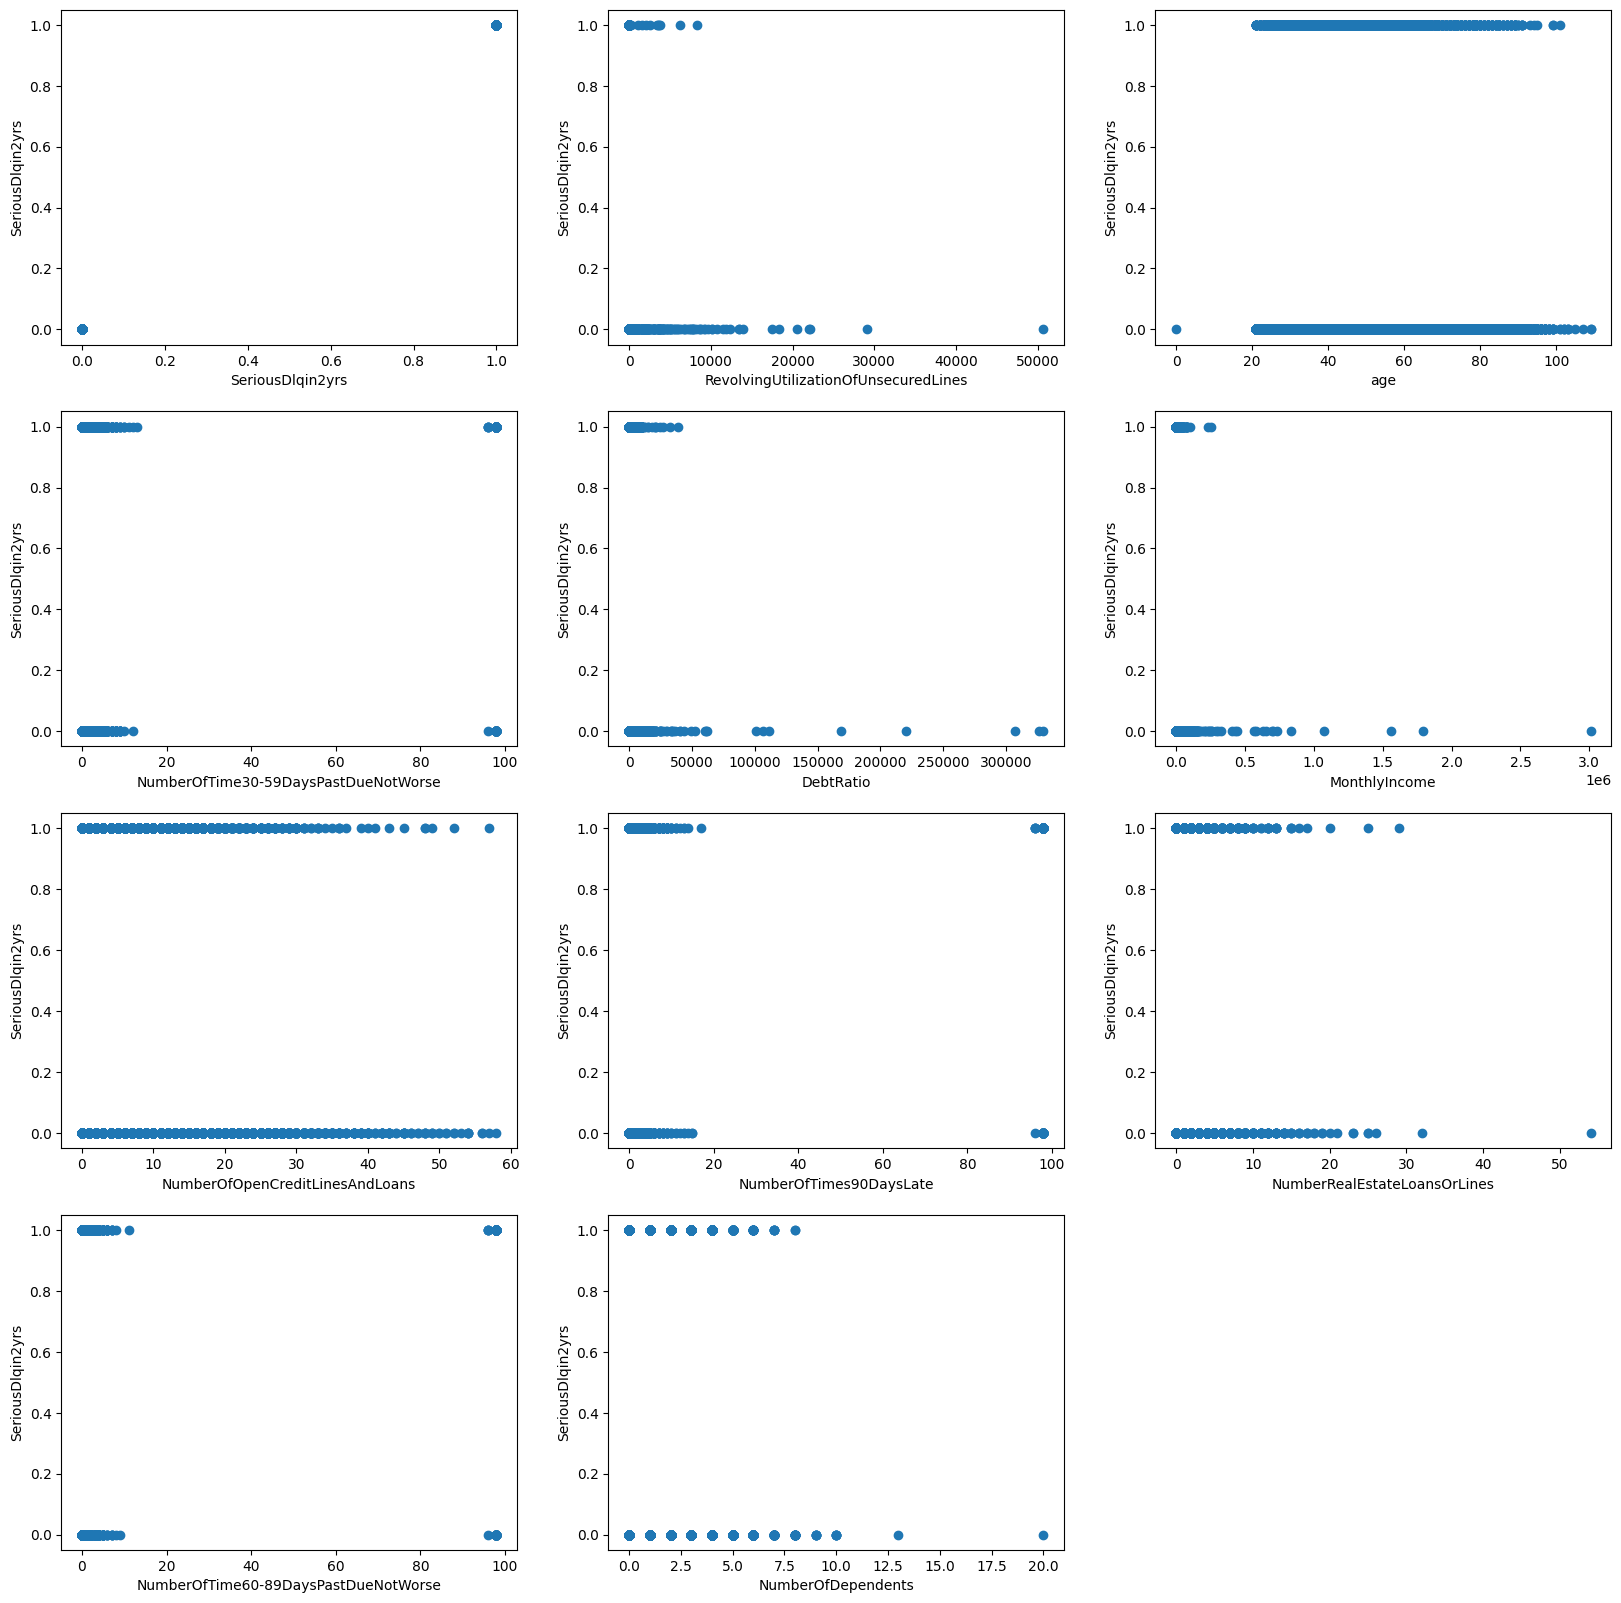

In [15]:
# vẽ biểu đồ phân bố của các cột
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_df.columns):
    plt.subplot(4, 3, i+1)
    plt.scatter(train_df[col], train_df['SeriousDlqin2yrs'])
    plt.xlabel(col)
    plt.ylabel('SeriousDlqin2yrs')

* Xoá bỏ điểm ngoại lai (Outlier)

In [16]:
train_df = train_df[train_df['RevolvingUtilizationOfUnsecuredLines'] < 50000]
train_df = train_df[train_df['age'] > 0]
train_df = train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse'] < 90]
train_df = train_df[train_df['DebtRatio'] < 300000]
train_df = train_df[train_df['MonthlyIncome'] < 3000000]
train_df = train_df[train_df['NumberOfTimes90DaysLate'] < 90]
train_df = train_df[train_df['NumberOfTime60-89DaysPastDueNotWorse'] < 90]
train_df = train_df[train_df['NumberOfDependents'] < 20]


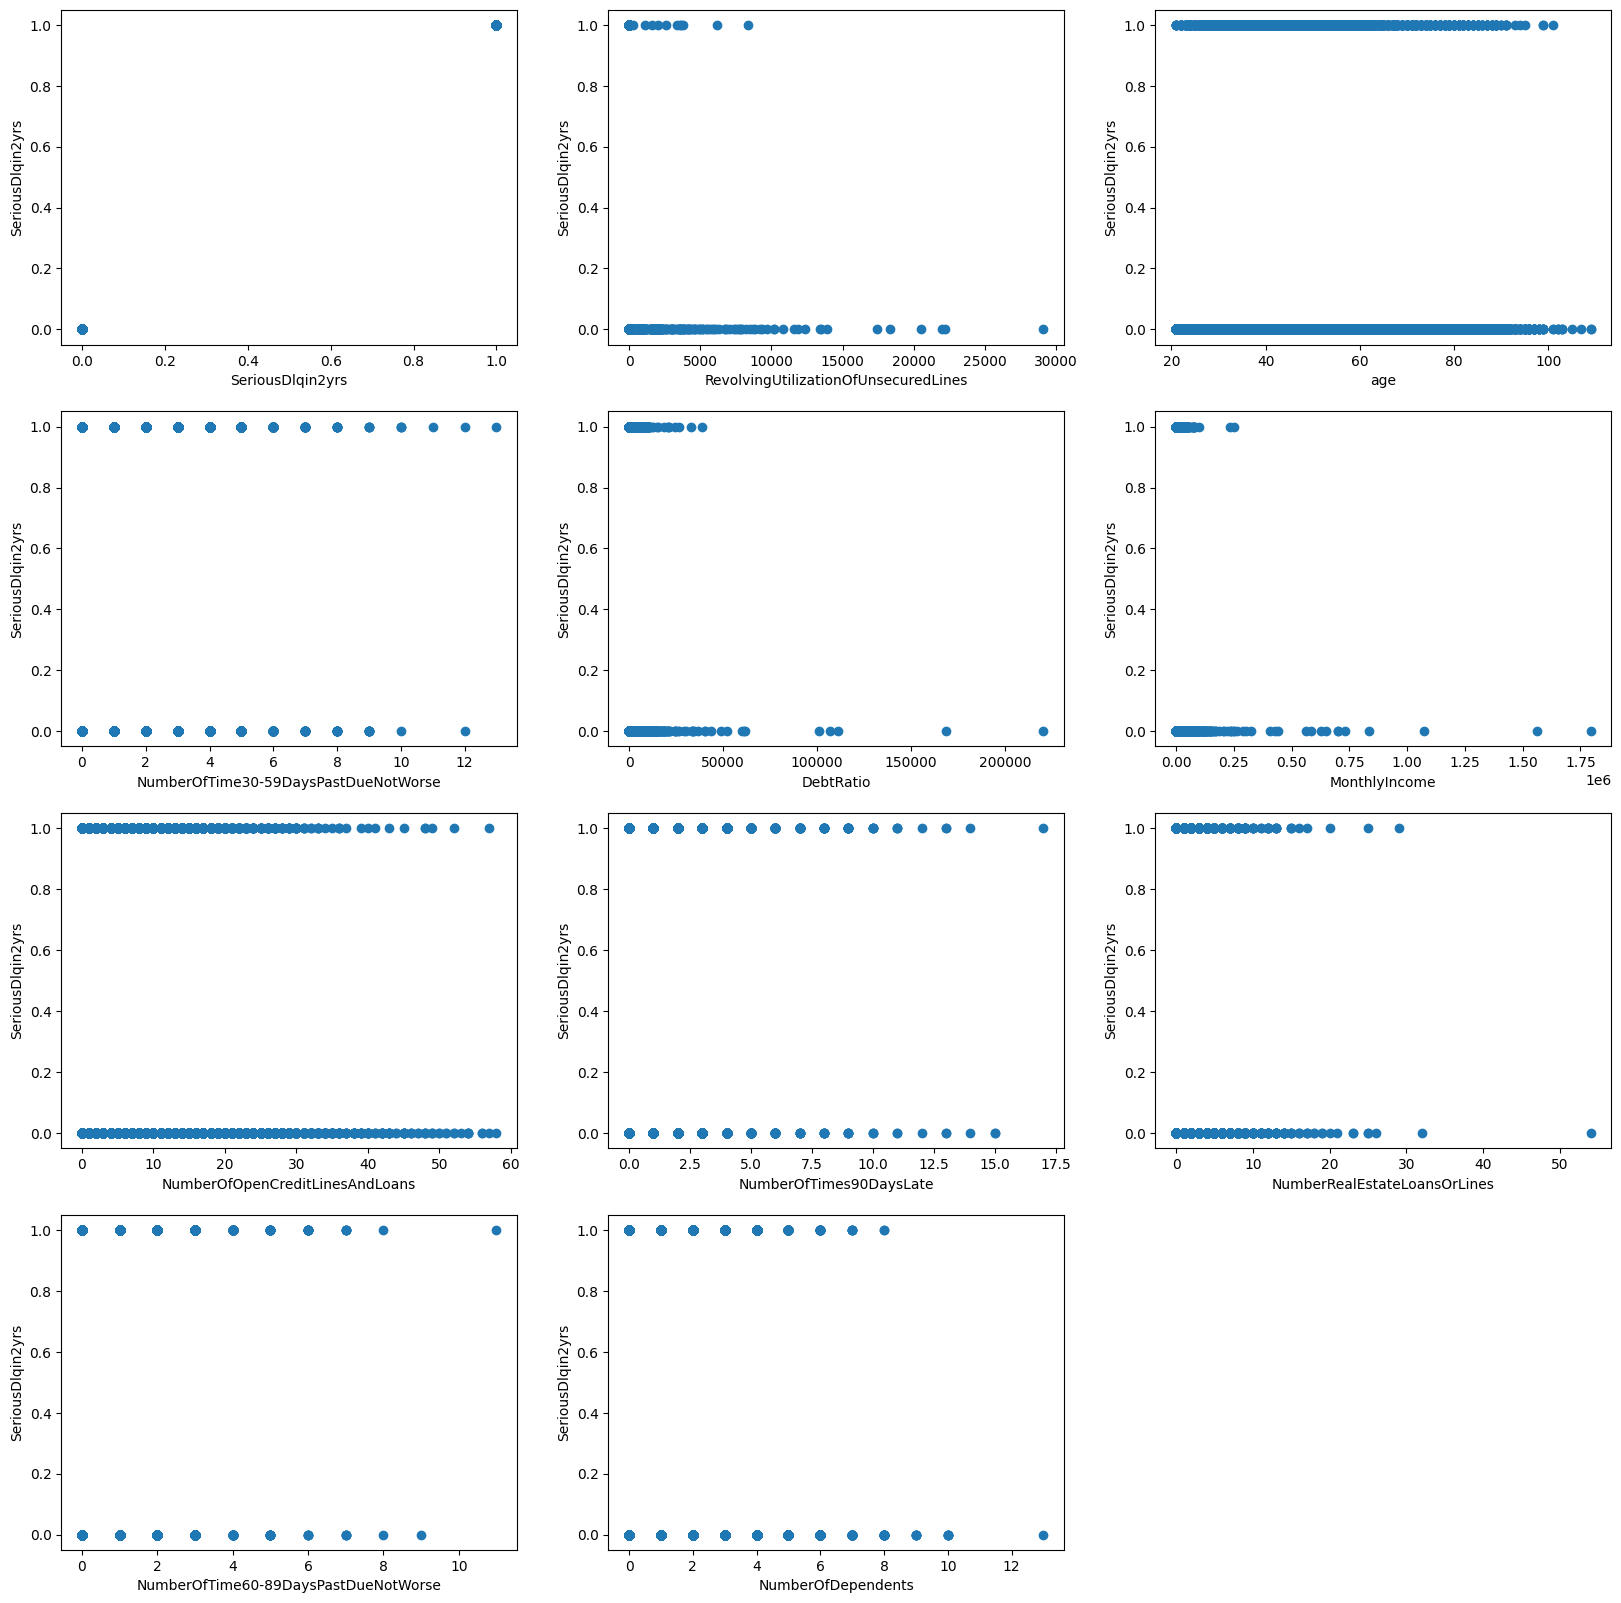

In [17]:
# Vẽ lại biểu đồ phân bố của các cột
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_df.columns):
    plt.subplot(4, 3, i+1)
    plt.scatter(train_df[col], train_df['SeriousDlqin2yrs'])
    plt.xlabel(col)
    plt.ylabel('SeriousDlqin2yrs')


In [18]:
train_df.shape

(149010, 11)

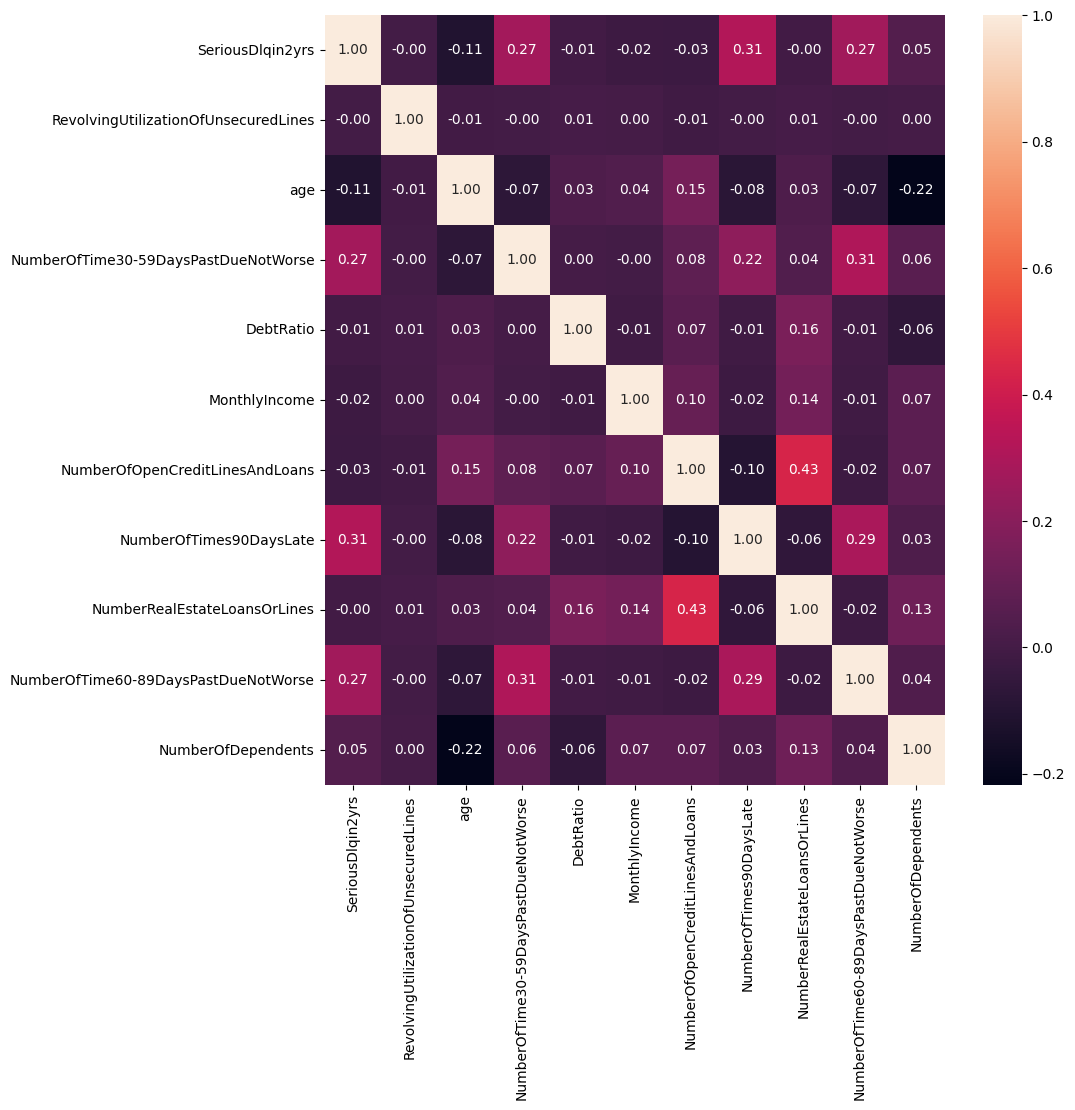

In [19]:
# Tương quan giữa các cột
corr = train_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()


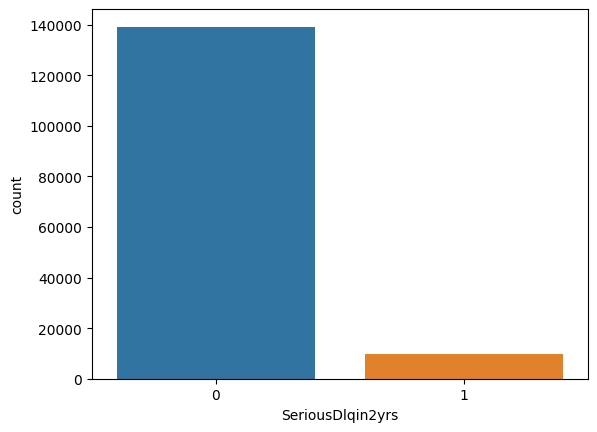

In [20]:
sns.countplot(x='SeriousDlqin2yrs', data=train_df)
plt.show()

Dữ liệu đang mất cân bằng (Imbalance Data) khi áp dụng vào mô hình học máy sẽ dẫn đến kết quả không chính xác. Vì vậy cần phải xử lý dữ liệu mất cân bằng này.

Ở đây sử dụng phương pháp SMOTE (Synthetic Minority Oversampling Technique) để xử lý dữ liệu mất cân bằng.


In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
X = train_df.drop('SeriousDlqin2yrs', axis=1)
y = train_df['SeriousDlqin2yrs']

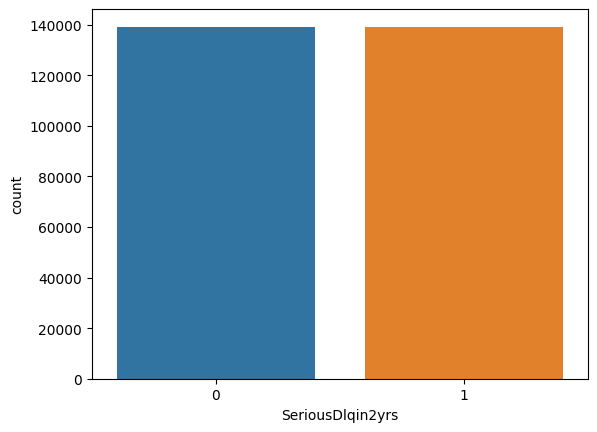

In [23]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X,y)
sns.countplot(x=y_smote)
plt.show()

* Chia dữ liệu thành 2 phần train và test

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [25]:
# Tìm tham số tốt nhất cho logistic regression
param_grid = {'C': [0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.669 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.674 total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.669 total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.1;, score=0.677 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=0.1;, score=0.669 total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.669 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.673 total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.669 total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.677 total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...............................C=1;, score=0.669 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.670 total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.670 total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.669 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.676 total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..............................C=10;, score=0.670 total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=100;, score=0.669 total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=100;, score=0.692 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=100;, score=0.669 total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=100;, score=0.677 total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=100;, score=0.670 total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=1000;, score=0.669 total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=1000;, score=0.673 total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=1000;, score=0.670 total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=1000;, score=0.676 total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=1000;, score=0.669 total time=   0.9s
{'C': 100}
LogisticRegression(C=100)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
# use best estimator
log_reg = grid.best_estimator_
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

print('Logistic Regression')
print('Accuracy : ', accuracy_score(y_val, y_pred_log))
print('F1 score : ', f1_score(y_val, y_pred_log))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_log))


Logistic Regression
Accuracy :  0.6722186287192755
F1 score :  0.6398862985846543
Confusion Matrix : 
 [[21205  6546]
 [11697 16208]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Tìm tham số tốt nhất cho decision tree
param_grid = {'max_depth': [3, 5, 7, 9, 11, 13, 15]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .......................max_depth=3;, score=0.749 total time=   0.2s
[CV 2/5] END .......................max_depth=3;, score=0.748 total time=   0.2s
[CV 3/5] END .......................max_depth=3;, score=0.750 total time=   0.2s
[CV 4/5] END .......................max_depth=3;, score=0.748 total time=   0.2s
[CV 5/5] END .......................max_depth=3;, score=0.749 total time=   0.2s
[CV 1/5] END .......................max_depth=5;, score=0.799 total time=   0.3s
[CV 2/5] END .......................max_depth=5;, score=0.800 total time=   0.3s
[CV 3/5] END .......................max_depth=5;, score=0.798 total time=   0.3s
[CV 4/5] END .......................max_depth=5;, score=0.800 total time=   0.3s
[CV 5/5] END .......................max_depth=5;, score=0.801 total time=   0.3s
[CV 1/5] END .......................max_depth=7;, score=0.832 total time=   0.4s
[CV 2/5] END .......................max_depth=7;,

In [28]:
# use best estimator
dt = grid.best_estimator_
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)

print('Decision Tree')
print('Accuracy : ', accuracy_score(y_val, y_pred_dt))
print('F1 score : ', f1_score(y_val, y_pred_dt))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_dt))


Decision Tree
Accuracy :  0.8678848641655886
F1 score :  0.8669068003692507
Confusion Matrix : 
 [[24356  3395]
 [ 3958 23947]]


In [29]:
# Tìm tham số tốt nhất cho random forest
param_grid = {'n_estimators': [100, 200, 300, 400,500]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................n_estimators=100;, score=0.907 total time=  19.4s
[CV 2/5] END ..................n_estimators=100;, score=0.906 total time=  19.0s
[CV 3/5] END ..................n_estimators=100;, score=0.908 total time=  19.6s
[CV 4/5] END ..................n_estimators=100;, score=0.905 total time=  19.0s
[CV 5/5] END ..................n_estimators=100;, score=0.907 total time=  19.3s
[CV 1/5] END ..................n_estimators=200;, score=0.908 total time=  38.5s
[CV 2/5] END ..................n_estimators=200;, score=0.908 total time=  38.1s
[CV 3/5] END ..................n_estimators=200;, score=0.909 total time=  38.1s
[CV 4/5] END ..................n_estimators=200;, score=0.907 total time=  37.9s
[CV 5/5] END ..................n_estimators=200;, score=0.908 total time=  37.8s
[CV 1/5] END ..................n_estimators=300;, score=0.908 total time=  57.0s
[CV 2/5] END ..................n_estimators=300;,

In [30]:
# use best estimator
rf = grid.best_estimator_
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print('Random Forest')
print('Accuracy : ', accuracy_score(y_val, y_pred_rf))
print('F1 score : ', f1_score(y_val, y_pred_rf))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_rf))


Random Forest
Accuracy :  0.9133426764409946
F1 score :  0.9134220115963883
Confusion Matrix : 
 [[25391  2360]
 [ 2463 25442]]


In [31]:
# Tìm tham số tốt nhất cho xgboost
param_grid = {'n_estimators': [100, 200, 300, 400,500]}
grid = GridSearchCV(XGBClassifier(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................n_estimators=100;, score=0.883 total time=   4.0s
[CV 2/5] END ..................n_estimators=100;, score=0.882 total time=   4.0s
[CV 3/5] END ..................n_estimators=100;, score=0.882 total time=   4.0s
[CV 4/5] END ..................n_estimators=100;, score=0.880 total time=   4.1s
[CV 5/5] END ..................n_estimators=100;, score=0.882 total time=   4.0s
[CV 1/5] END ..................n_estimators=200;, score=0.890 total time=   7.8s
[CV 2/5] END ..................n_estimators=200;, score=0.889 total time=   7.7s
[CV 3/5] END ..................n_estimators=200;, score=0.890 total time=   7.8s
[CV 4/5] END ..................n_estimators=200;, score=0.888 total time=   7.9s
[CV 5/5] END ..................n_estimators=200;, score=0.889 total time=   7.9s
[CV 1/5] END ..................n_estimators=300;, score=0.895 total time=  11.8s
[CV 2/5] END ..................n_estimators=300;,

In [32]:
# use best estimator
xgb = grid.best_estimator_
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

print('XGBoost')
print('Accuracy : ', accuracy_score(y_val, y_pred_xgb))
print('F1 score : ', f1_score(y_val, y_pred_xgb))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_xgb))


XGBoost
Accuracy :  0.901897369555843
F1 score :  0.9008642602948652
Confusion Matrix : 
 [[25388  2363]
 [ 3097 24808]]


* Áp dụng tham số tối ưu cho mô hình tự xây dựng

Logistic Regression

## Hồi quy Logistic (Logistic Regression)

### Giới thiệu
- **Hồi quy Logistic**: Mô hình xác suất kết quả nhị phân.
- **Ứng dụng**: Phân loại.
- **Đặc điểm**: Sử dụng hàm logistic có hình dạng "S" thay vì đường thẳng.

### Công thức chính
- **Hàm logistic (sigmoid)**:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
- **Hàm đầu vào tổng**:
$$
z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n
$$
- **Hàm chi phí với chuẩn hóa**:
$$
J(w) = -\sum_{i=1}^{m} [y^{(i)} \log(\sigma(z^{(i)})) + (1 - y^{(i)}) \log(1 - \sigma(z^{(i)}))] + C \sum_{j=1}^{n} w_j^2
$$


### Tham số
- **eta**: Tốc độ học.
- **n_iter**: Số lần qua lại trên tập dữ liệu.
- **C**: Độ mạnh của chuẩn hóa.
- **random_state**: Khởi tạo trọng số ngẫu nhiên.

### Thuật toán
1. Khởi tạo trọng số.
2. Cập nhật trọng số qua mỗi vòng lặp dựa trên dự đoán và sai số thực tế.
3. Dự đoán lớp dựa trên trọng số cuối cùng.


In [33]:
# logistic regression
class my_Logistic_Regresion(object):
    def __init__(self, eta, n_iter, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y, C=0.1):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * (X.T.dot(errors) - C * self.w_[1:])
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))) + C * np.sum(self.w_[1:] ** 2)
            self.cost_.append(cost)

        return self

    
    def net_input(self, X):
        return np.dot(X,self.w_[1:])+self.w_[0]
    
    def activation(self, z):
        return 1/(1+np.exp(-np.clip(z,-250,250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [34]:
# use my logistic regression with C=10
my_log_reg = my_Logistic_Regresion(eta=0.001, n_iter=1000)
my_log_reg.fit(X_train, y_train, C=10)
y_pred_log = my_log_reg.predict(X_val)

print('My Logistic Regression')
print('Accuracy : ', accuracy_score(y_val, y_pred_log))
print('F1 score : ', f1_score(y_val, y_pred_log))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_log))

/var/folders/c_/qrxv7nvn2mnb7yw_7zldqky40000gn/T/ipykernel_71348/3617625910.py:19: RuntimeWarning: divide by zero encountered in log
  cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))) + C * np.sum(self.w_[1:] ** 2)


My Logistic Regression
Accuracy :  0.5013834986344688
F1 score :  0.6678953100130443
Confusion Matrix : 
 [[    0 27751]
 [    0 27905]]


Decision Tree

# Decision Tree (Cây quyết định)

Decision Tree là một trong những thuật toán học máy được sử dụng phổ biến. Nó hoạt động bằng cách chia tập dữ liệu thành các nhóm nhỏ hơn dựa trên các tiêu chí quyết định cho đến khi đạt được một sự phân loại hoàn chỉnh hoặc đạt mức độ sâu tối đa của cây.

## Cấu trúc Cây Quyết Định

- **TreeNode**: Là một đơn vị cơ bản trong cây, chứa:
  - `data`: Chỉ số của thuộc tính (feature) được sử dụng để phân chia dữ liệu tại nút này.
  - `children`: Một từ điển chứa các giá trị của thuộc tính tại `data` và các nút con tương ứng.
  - `output`: Là kết quả dự đoán tại nút này.
  - `index`: Dùng cho việc vẽ cây.

## Công thức và hàm số

### 1. Entropy:

$$
Entropy(S) = - \sum p_i \log_2(p_i)
$$

Trong đó, \( p_i \) là xác suất của lớp thứ \( i \) trong tập \( S \).

### 2. Gain Ratio:

$$
GainRatio(S, A) = \frac{InformationGain(S, A)}{SplitInformation(S, A)}
$$

### 3. Gini Index:

$$
GiniIndex(S) = 1 - \sum (p_i)^2
$$

Trong đó, \( p_i \) là xác suất của lớp thứ \( i \) trong tập \( S \).

## Thuật toán

- **__decision_tree**: Đây là hàm đệ quy chính. Tại mỗi bước, nó sẽ chọn ra thuộc tính có giá trị Gain Ratio hoặc Gini Gain tốt nhất để phân chia dữ liệu. Điều này sẽ tiếp tục cho đến khi tất cả dữ liệu thuộc cùng một lớp hoặc không còn thuộc tính nào để kiểm tra.

- **fit**: Khởi tạo cây quyết định bằng cách gọi hàm `__decision_tree`.

- **predict**: Dự đoán nhãn của mỗi mẫu dữ liệu trong tập X.

- **score**: Tính toán độ chính xác của mô hình dựa trên dự đoán và nhãn thực sự.

- **export_tree_pdf**: Xuất cây ra dưới dạng đồ thị (sử dụng thư viện pydotplus).

## Điểm chú ý

- Thuật toán Decision Tree có thể dễ dàng quá khớp (overfit) nếu cây quá sâu. Một cách giải quyết là cắt tỉa cây (pruning) hoặc thiết lập độ sâu tối đa.
- Cây Quyết Định rất nhạy cảm với việc thay đổi dữ liệu. Một thay đổi nhỏ cũng có thể dẫn đến một cây hoàn toàn khác.
- Lớp `my_DecisionTreeClassifier` đã được triển khai ở trên chỉ hỗ trợ phân loại dựa trên thuộc tính rời rạc.


In [35]:
import math
import numpy as np
import pandas as pd

class TreeNode:
    def __init__(self, data, output):
        self.data = data
        self.children = {}
        self.output = output
        self.index = -1
        
    def add_child(self, feature_value, obj):
        self.children[feature_value] = obj

class DecisionTreeClassifier:
    def __init__(self):
        self.__root = None

    def __count_unique(self, Y):
        return dict(pd.Series(Y).value_counts())

    def __entropy(self, Y):
        freq_map = self.__count_unique(Y)
        entropy_ = sum([-p*math.log2(p) for p in (freq_map[i]/len(Y) for i in freq_map)])
        return entropy_

    def __gain_ratio(self, X, Y, selected_feature):
        info_orig = self.__entropy(Y)
        info_f = 0
        split_info = 0
        values = set(X[:, selected_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        initial_size = df.shape[0]
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            info_f += (current_size/initial_size)*self.__entropy(df1[df1.shape[1]-1])
            split_info += (-current_size/initial_size)*math.log2(current_size/initial_size)
        if split_info == 0:
            return math.inf
        info_gain = info_orig - info_f
        gain_ratio = info_gain / split_info
        return gain_ratio

    def __gini_index(self, Y):
        freq_map = self.__count_unique(Y)
        gini_index_ = 1 - sum([(freq_map[i]/len(Y))**2 for i in freq_map])
        return gini_index_

    def __gini_gain(self, X, Y, selected_feature):
        gini_orig = self.__gini_index(Y)
        gini_split_f = 0
        values = set(X[:, selected_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        initial_size = df.shape[0]
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            gini_split_f += (current_size/initial_size)*self.__gini_index(df1[df1.shape[1]-1])
        gini_gain_ = gini_orig - gini_split_f
        return gini_gain_

    def __decision_tree(self, X, Y, features, level, metric, classes):
        if len(set(Y)) == 1:
            return TreeNode(None, list(set(Y))[0])
        if len(features) == 0:
            return TreeNode(None, pd.Series(Y).mode()[0])
        max_gain = -math.inf
        final_feature = None
        for f in features:
            if metric == "gain_ratio":
                current_gain = self.__gain_ratio(X, Y, f)
            else:
                current_gain = self.__gini_gain(X, Y, f)
            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f
        unique_values = set(X[:, final_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        current_node = TreeNode(final_feature, pd.Series(Y).mode()[0])
        index = features.index(final_feature)
        features.remove(final_feature)
        for i in unique_values:
            df1 = df[df[final_feature] == i]
            node = self.__decision_tree(df1.iloc[:, 0:df1.shape[1]-1].values, df1.iloc[:, df1.shape[1]-1].values, features, level+1, metric, classes)
            current_node.add_child(i, node)
        features.insert(index, final_feature)
        return current_node

    def fit(self, X, Y, metric="gain_ratio"):
        features = [i for i in range(X.shape[1])]
        classes = set(Y)
        level = 0
        if metric != "gain_ratio" and metric != "gini_index":
            metric = "gain_ratio"
        self.__root = self.__decision_tree(X, Y, features, level, metric, classes)

    def __predict_for(self, data, node):
        if len(node.children) == 0:
            return node.output
        val = data[node.data]
        if val not in node.children:
            return node.output
        return self.__predict_for(data, node.children[val])

    def predict(self, X):
        Y = np.array([self.__predict_for(i, self.__root) for i in X])
        return Y

    def score(self, X, Y):
        Y_pred = self.predict(X)
        count = (Y_pred == Y).sum()
        return count / len(Y_pred)

    def export_tree_pdf(self, filename=None):
        import pydotplus
        from collections import deque
        dot_data = '''digraph Tree {node [shape=box] ;}'''
        queue = deque([self.__root])
        count = 0
        self.__root.index = count
        while queue:
            node = queue.popleft()
            for i in node.children:
                count += 1
                child = node.children[i]
                child.index = count
                dot_data += "\n{} -> {} [label=\"{}\"];".format(node.index, child.index, i)
                queue.append(child)
        if filename:
            graph = pydotplus.graph_from_dot_data(dot_data)
            graph.write_pdf(filename)
        return dot_data


In [36]:
# use my decision tree with gain_ratio
my_dt = DecisionTreeClassifier()
my_dt.fit(X_train.values, y_train.values, metric="gain_ratio")
y_pred_dt = my_dt.predict(X_val.values)

print('My Decision Tree')
print('Accuracy : ', accuracy_score(y_val, y_pred_dt))
print('F1 score : ', f1_score(y_val, y_pred_dt))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_dt))

My Decision Tree
Accuracy :  0.6079308610033061
F1 score :  0.40769794522407093
Confusion Matrix : 
 [[26325  1426]
 [20395  7510]]


Random Forest

# Random Forest (Rừng Ngẫu Nhiên)

Random Forest là một thuật toán phân loại và hồi quy phổ biến trong học máy. Nó là một phần của Ensemble Learning, xây dựng nhiều cây quyết định độc lập để cải thiện dự đoán và giảm overfitting.

## Cấu trúc của Lớp my_RandomForest

- `n_trees`: Số lượng cây quyết định con trong rừng.
- `max_features`: Số lượng đặc trưng tối đa được sử dụng khi xây dựng cây con.
- `max_depth`: Độ sâu tối đa cho mỗi cây con.

## Các Phương Thức

- `fit(X, y)`: Huấn luyện mô hình Random Forest trên tập dữ liệu huấn luyện X với nhãn y.
- `predict(X)`: Dự đoán nhãn cho tập dữ liệu X bằng cách kết hợp dự đoán từ tất cả các cây con.
- `score(X, y)`: Tính toán độ chính xác của mô hình trên tập dữ liệu X so với nhãn thực sự y.

## Thuật Toán Random Forest

- Khởi tạo danh sách rỗng để lưu trữ các cây quyết định con.
- Lặp qua mỗi cây con:
  - Thực hiện Bootstrap sampling để tạo tập dữ liệu con.
  - Xây dựng cây quyết định con với giới hạn độ sâu và đặc trưng.
- Tổng hợp dự đoán từ tất cả các cây con để đưa ra dự đoán cuối cùng.

## Công Thức Tổng Hợp Dự Đoán (Voting)

Dự đoán cuối cùng được tính bằng cách lựa chọn giá trị xuất hiện nhiều nhất (mode) từ các dự đoán của các cây con.

$$
pred = \text{mode(predictions from all trees)}
$$



In [45]:

class my_RandomForest:
    from sklearn.tree import DecisionTreeClassifier
    def __init__(self, n_trees=10, max_features='sqrt', max_depth=None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape

        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        else:
            raise ValueError("Invalid value for max_features")

        for _ in range(self.n_trees):
            # Bootstrap sampling
            X_sample, y_sample = resample(X, y)
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        y_pred = np.squeeze(stats.mode(tree_preds, axis=0).mode)
        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy


In [46]:
forest = my_RandomForest(n_trees=100, max_features='sqrt')
forest.fit(X_train, y_train)
y_pred_rf = forest.predict(X_val)

print('My Random Forest')
print('Accuracy : ', accuracy_score(y_val, y_pred_rf))
print('F1 score : ', f1_score(y_val, y_pred_rf))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_rf))

/var/folders/c_/qrxv7nvn2mnb7yw_7zldqky40000gn/T/ipykernel_71348/3898536060.py:31: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred = np.squeeze(stats.mode(tree_preds, axis=0).mode)


My Random Forest
Accuracy :  0.912659910881127
F1 score :  0.9126143779100077
Confusion Matrix : 
 [[25412  2339]
 [ 2522 25383]]


* Áp dụng mô hình học máy với các tham số tối ưu đã tìm được triển khai bằng SKlearn

In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Logistic Regression
log_reg = LogisticRegression(C=10)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=15)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)

# Random Forest
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)


In [48]:
print('Logistic Regression')
print('Accuracy : ', accuracy_score(y_val, y_pred_log))
print('F1 score : ', f1_score(y_val, y_pred_log))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_log))
print('------------------------------------------------------------')
print('Decision Tree')
print('Accuracy : ', accuracy_score(y_val, y_pred_dt))
print('F1 score : ', f1_score(y_val, y_pred_dt))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_dt))
print('------------------------------------------------------------')
print('Random Forest')
print('Accuracy : ', accuracy_score(y_val, y_pred_rf))
print('F1 score : ', f1_score(y_val, y_pred_rf))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_rf))



Logistic Regression
Accuracy :  0.6947858272243783
F1 score :  0.6782947938564097
Confusion Matrix : 
 [[20761  6990]
 [ 9997 17908]]
------------------------------------------------------------
Decision Tree
Accuracy :  0.8684957596665229
F1 score :  0.867646792889564
Confusion Matrix : 
 [[24347  3404]
 [ 3915 23990]]
------------------------------------------------------------
Random Forest
Accuracy :  0.9138277993387954
F1 score :  0.9138989623352841
Confusion Matrix : 
 [[25407  2344]
 [ 2452 25453]]


<h3>----> Thông qua việc gọi mô hình trong thư viện SKlearn để so sánh kết quả với mô hình tự xây dựng, cho thấy kết quả của mô hình tự xây dựng có độ chính xác khá thâp so với mô hình trong thư viện SKlearn. Do đó, cần phải tìm hiểu thêm về các thuật toán để cải thiện mô hình. Duy nhất chỉ có mô hình Random Forest có độ chính xác khá cao so với các mô hình còn lại. Từ đó, có thể thấy được mô hình Random Forest là mô hình phù hợp nhất cho bài toán này.</h3>

## Sử dụng thêm mô hình XGBoost để đánh giá

# XGBoost (Extreme Gradient Boosting) Classifier

XGBoost (Extreme Gradient Boosting) là một trong những thuật toán học máy mạnh mẽ và phổ biến được sử dụng cho bài toán phân loại và hồi quy. Đây là một thuật toán Gradient Boosting Tree, trong đó các cây quyết định được xây dựng theo chuỗi và được tối ưu hóa để cải thiện độ chính xác của mô hình.

## Cách XGBoost Hoạt Động

1. **Boosting Trees**: XGBoost sử dụng nhiều cây quyết định để thực hiện dự đoán. Các cây này, thường được gọi là "weak learners," được kết hợp để tạo thành một "strong learner." Mỗi cây quyết định thường được xây dựng để sửa các sai số của cây trước đó.

2. **Tối Ưu Hóa Hàm Mất Mát**: XGBoost sử dụng một hàm mất mát cụ thể (thường là hàm mất mát log likelihood cho bài toán phân loại) để đánh giá chất lượng dự đoán và tối ưu hóa nó trong quá trình xây dựng cây. Hàm mất mát này cần được tối thiểu hóa để tạo ra các cây quyết định tốt nhất.

3. **Regularization (Chống Quá Khớp)**: Để ngăn ngừa hiện tượng quá khớp, XGBoost sử dụng các kỹ thuật chính quy như L1 (chính quy Lasso) và L2 (chính quy Ridge) trên các cây quyết định.

4. **Dừng Sớm (Early Stopping)**: XGBoost có khả năng dừng quá trình xây dựng cây nếu không có sự cải thiện đáng kể trong việc giảm mất mát.

## Công Thức Toán Học

### Hàm Mất Mát

XGBoost sử dụng một hàm mất mát phụ thuộc vào loại bài toán (phân loại hoặc hồi quy), nhưng một trong những hàm mất mát phổ biến nhất cho bài toán phân loại là hàm mất mát log likelihood:

$$
\text{Loss}(y, \hat{y}) = -\sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]
$$

Trong đó:
\begin{align*}
y_i & \text{ là nhãn thực sự của mẫu } i. \\
\hat{y}_i & \text{ là xác suất dự đoán của mẫu } i \text{ thuộc lớp tích cực (1).} \\
\end{align*}
### Công Thức Cập Nhật Trọng Số

XGBoost sử dụng Gradient Descent để tối ưu hóa hàm mất mát. Công thức cập nhật trọng số cho các cây quyết định là:

$$
w_i^{(t+1)} = w_i^{(t)} + \epsilon \cdot \frac{\partial \text{Loss}(y_i, \hat{y}_i^{(t)})}{\partial \hat{y}_i^{(t)}}
$$

Trong đó:
\begin{align*}
w_i^{(t)} & \text{ là trọng số của mẫu } i \text{ tại vòng lặp } t. \\
\hat{y}_i^{(t)} & \text{ là xác suất dự đoán của mẫu } i \text{ tại vòng lặp } t. \\
\epsilon & \text{ là tỷ lệ học tập, quyết định độ điều chỉnh trọng số sau mỗi vòng lặp.} \\
\frac{\partial \text{Loss}(y_i, \hat{y}_i^{(t)})}{\partial \hat{y}_i^{(t)}} & \text{ là đạo hàm riêng của hàm mất mát theo xác suất dự đoán } \hat{y}_i^{(t)}.
\end{align*}

## Ưu Điểm của XGBoost

- Độ chính xác cao.
- Hiệu suất tốt.
- Hỗ trợ cả phân loại và hồi quy.
- Hoạt động tốt với dữ liệu có kích thước và số chiều lớn.
- Hỗ trợ tính toán song song.

XGBoost là một thuật toán mạnh mẽ và được sử dụng rộng rãi trong thực tế cũng như trong các cuộc thi học máy.


In [49]:
# XGBoost
xgb = XGBClassifier(n_estimators=500)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

In [50]:
print('XGBoost')
print('Accuracy : ', accuracy_score(y_val, y_pred_xgb))
print('F1 score : ', f1_score(y_val, y_pred_xgb))
print('Confusion Matrix : \n', confusion_matrix(y_val, y_pred_xgb))

XGBoost
Accuracy :  0.9033707057639787
F1 score :  0.9023389264182465
Confusion Matrix : 
 [[25433  2318]
 [ 3060 24845]]


<h3>---> Kết quả cho thấy độ chính xác của mô hình khá cao khoảng 90% nhưng vẫn thấp hơn mô hình Random Forest. Vì vậy mô hình tốt nhất là Random Forest sẽ được lưu lại và sử dụng để dự đoán file test_data</h3>

## Lưu mô hình Random Forest

In [51]:
import pickle
pickle.dump(rf, open('model.pkl','wb'))

## Vẽ đồ thị ROC

In [52]:
def plot_roc(y_test,prob):
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve

    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = auc(fpr,tpr)
    plt.figure(1)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.plot(fpr,tpr,'r',label= 'AUC= {:.3f}'.format(auc))
    plt.legend(loc='lower right')
    plt.plot(fpr,tpr, marker='.')
    plt.title("ROC Curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()
    print('AUC Score: ', auc)

* Logistic Regression

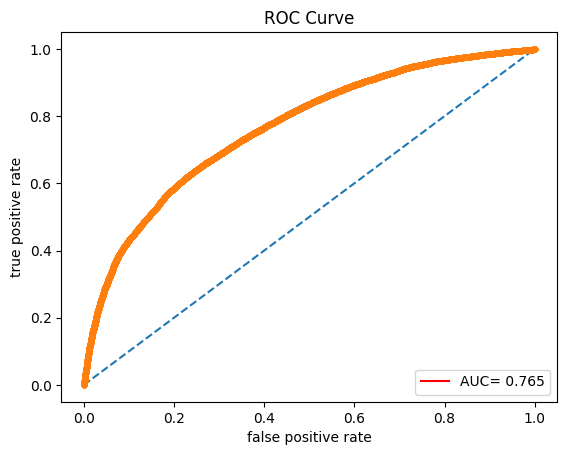

AUC Score:  0.7653273904404354


In [53]:
# roc for logistic regression
prob = log_reg.predict_proba(X_val)
prob = prob[:,1]
plot_roc(y_val,prob)


* Decision Tree

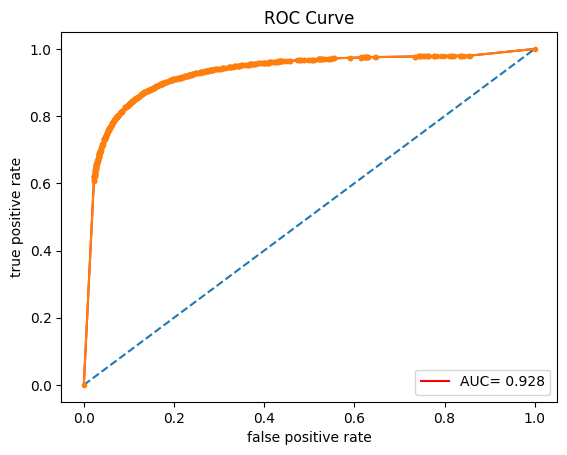

AUC Score:  0.9276766999768354


In [54]:
# roc for decision tree
prob = dt.predict_proba(X_val)
prob = prob[:,1]
plot_roc(y_val,prob)


* Random Forest

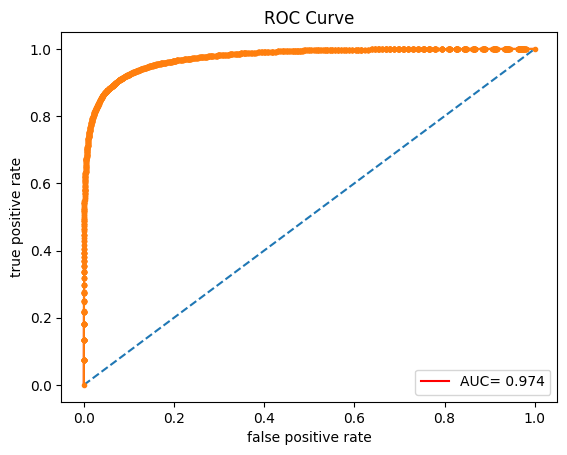

AUC Score:  0.9737569776626789


In [55]:
# roc for random forest
prob = rf.predict_proba(X_val)
prob = prob[:,1]
plot_roc(y_val,prob)


* XGBoost

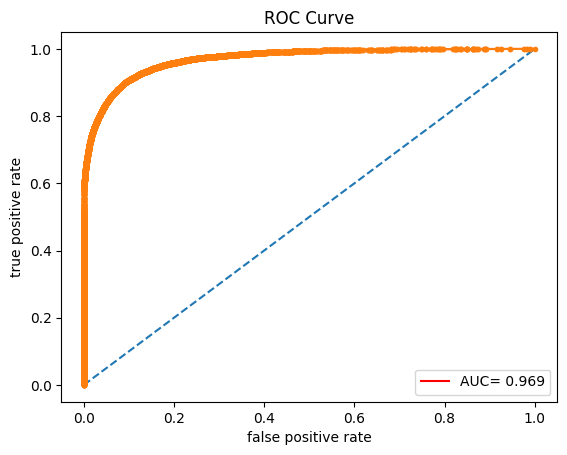

AUC Score:  0.9692262231312396


In [56]:
# roc for xgboost
prob = xgb.predict_proba(X_val)
prob = prob[:,1]
plot_roc(y_val,prob)


# Test với file test_data

In [57]:
model = pickle.load(open('model.pkl','rb'))

In [58]:
test_df.isna().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [59]:
test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].mean(), inplace=True)
test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].mode()[0], inplace=True)

In [60]:
test_df.isna().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

In [61]:
test_data = test_df.drop('SeriousDlqin2yrs', axis=1)

test_data = scaler.transform(test_data)

model = pickle.load(open('model.pkl','rb'))
y_pred = model.predict_proba(test_data)[:,1]

In [63]:
print(y_pred[:5])
print(entry_df.head())


[0.138      0.092      0.01       0.136      0.22498978]
   Id  Probability
0   1     0.080807
1   2     0.040719
2   3     0.011968
3   4     0.067640
4   5     0.108264


0    90462
1    11041
dtype: int64


<Axes: ylabel='count'>

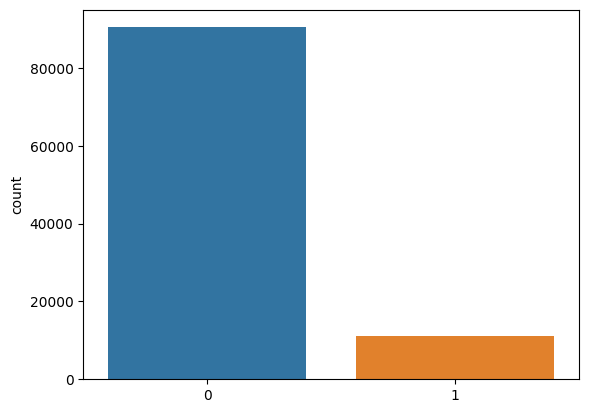

In [64]:
target = model.predict(test_data)
print(pd.Series(target).value_counts())

sns.countplot(x=target)

--> Tỷ lệ dự đoán khá đúng với biểu đồ countplot đã vẽ ban đầu